In [1]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine,Inspector
import json
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import reliability.Fitters as F
import reliability.Distributions as D
from datetime import datetime as dt
from sqlalchemy import text
today = dt.today().strftime('%Y-%m-%d')

In [2]:
plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
today = dt.today().strftime('%Y-%m-%d')

In [3]:
# 定义数据库连接信息
db_username = 'develop'
db_password = 'Dev&168!'
db_port = '3306'
# db_hostname = '172.24.139.117'
# db_name = 'zlaq_gd_ana'

In [4]:
db_name = 'zlaq_prod'
db_hostname = '172.24.139.206'

In [5]:
# 创建数据库连接字符串
db_connection_str = f'mysql+pymysql://{db_username}:{db_password}@{db_hostname}:{db_port}/{db_name}'

In [6]:
# 创建数据库连接引擎
engine = create_engine(db_connection_str)
inspector = Inspector.from_engine(engine)
tables = inspector.get_table_names()

C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_8524\180711921.py:3: SADeprecationWarning: The from_engine() method on Inspector is deprecated and will be removed in a future release.  Please use the sqlalchemy.inspect() function on an Engine or Connection in order to acquire an Inspector. (deprecated since: 1.4)
  inspector = Inspector.from_engine(engine)


In [ ]:
### 索赔单
claims_sql = '''
select * from
(select claim_guarantee_code,vin,guarantee_amount,
delivery_time,fault_time,
driving_mileage,
damage_material_code,damage_material_name,
vehicle_category_code,LEFT(vehicle_category_code,1) as vehicle_cate_merge,
usage_type_name
 from dwd_aftersale_claim_guarantee_order_df
where 1=1 
    and usage_type_name = '销售用车'
    and damage_material_code = 'M01-81030002'
) raw
where 1=1 
and vehicle_cate_merge = 'M'
'''
claims_raw = pd.read_sql(claims_sql, engine)

In [9]:
###里程
mils_query = '''
select vin,total_odometer from dm_vom_drive_total_sum_df 
'''
# dm_vom_adas_total_odometer  
# dm_vom_drive_total_sum_df


mils_raw = pd.read_sql(mils_query, engine)

In [13]:
###车辆
vehicle_query = '''
select vin,vehicle_series_category_code,vehicle_model_name,factory_name,year_size,
left(actual_product_finish_time,10) as product_date, left(product_delivery_time,10) as delivery_date
from dim_pro_prod_vehicle_base_info_df 
where 1=1 
and left(vehicle_series_category_code,1)  = 'M'
and product_delivery_time is not null
'''
vehicle_raw = pd.read_sql(vehicle_query, engine)


In [18]:
# assert 3>4, "Houston we've got a problem"
claims = claims_raw.copy()
mils = mils_raw.copy()
vehicle = vehicle_raw.copy()

claims = claims.merge(vehicle[['vin','delivery_date','product_date']],how='left',on='vin')
vehicle = vehicle.merge(mils,on='vin')
vehicle['use_days'] = (pd.to_datetime('2024-07-03') - pd.to_datetime(vehicle['delivery_date'])).dt.days
vehicle['use_days'] = vehicle['use_days'].apply( lambda x: x if x > 1 else 1)
claims['use_days']= (pd.to_datetime(claims['fault_time']) - pd.to_datetime(claims['delivery_time'])).dt.days
claims['use_days'] = claims['use_days'].apply( lambda x: x if x > 1 else 1)
claims['total_odometer'] = claims['driving_mileage']
#assert 3>4, "Houston we've got a problem"

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2036/170060 (98.81694% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1383.02         3.90178   1375.39   1390.69
     Beta         16.6071        0.234421   16.1539   17.0729 

Goodness of fit    Value
 Log-likelihood -18548.4
           AICc  37100.8
            BIC  37120.9
             AD  833.651 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 6777/33350 (83.11112% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1738.34         3.72335   1731.06   1745.66
     Beta         8.75901       0.0847432   8.59448   8.92668 

Goodness of fit    Value
 Log-likelihood -57506.1
           AICc   115016
            BIC   115033
             AD  635.405 



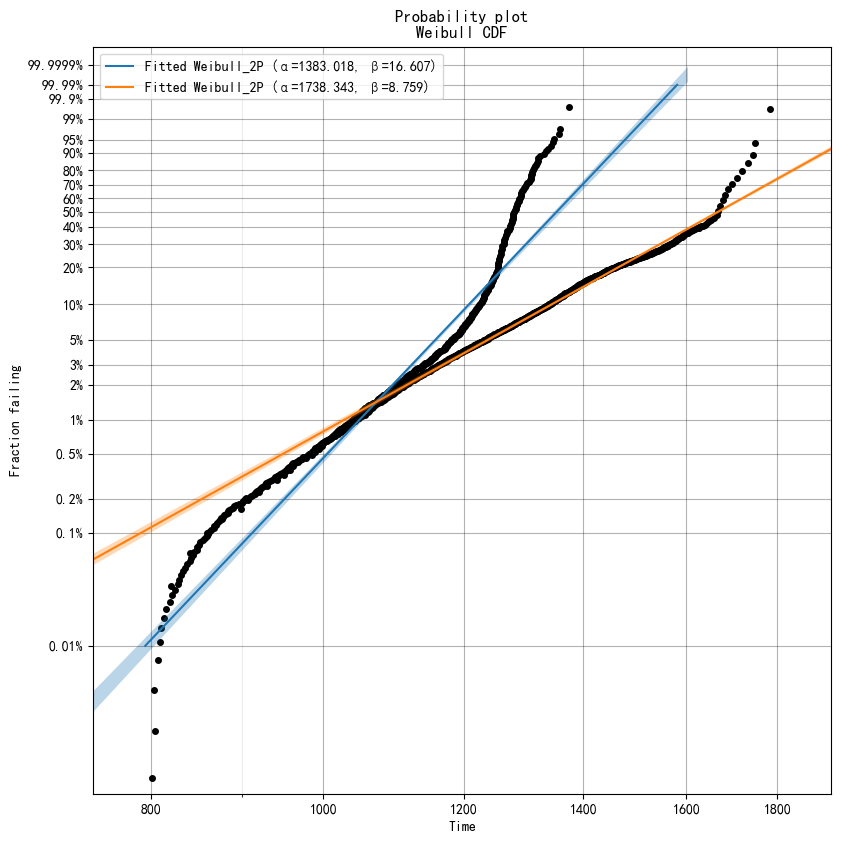

In [19]:
left_data = claims.loc[(claims['product_date']>'2021-01-15')&(
                        claims['use_days']>800)]
right_data= vehicle.loc[(vehicle['product_date']>'2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]
output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
# plt.title('断点后-里程')

left_data = claims.loc[(claims['product_date']<='2021-01-15')&(
                        claims['use_days']>800)]
right_data= vehicle.loc[(vehicle['product_date']<='2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]
output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
# plt.title('断点后-里程')

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2363/170060 (98.62953% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha          318834         6246.66    306823    331316
     Beta         2.72719       0.0372428   2.65516   2.80117 

Goodness of fit    Value
 Log-likelihood -36837.8
           AICc  73679.6
            BIC  73699.7
             AD    37220 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 6909/33350 (82.83862% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha          184505         1284.66    182004    187040
     Beta         2.39386       0.0211383   2.35279   2.43565 

Goodness of fit   Value
 Log-likelihood  -93931
           AICc  187866
            BIC  187883
             AD 15328.8 



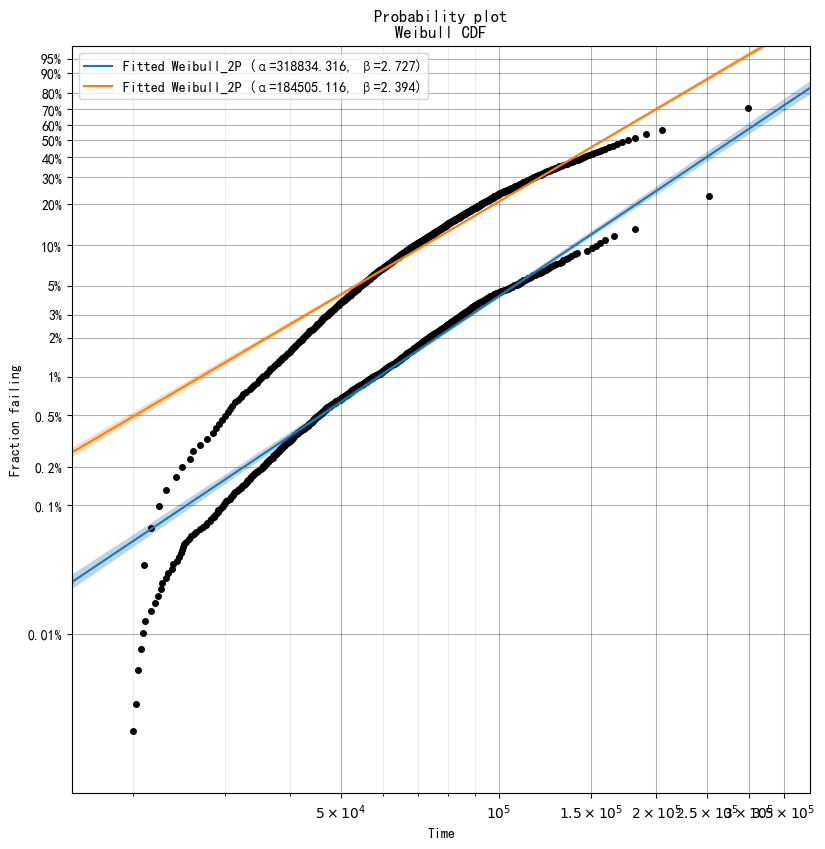

In [21]:
#assert 3>4, "Houston we've got a problem"
#故障件预处理

left_data = claims.loc[(claims['product_date']>'2021-01-15')&
                       (claims['total_odometer']>20000)]
right_data= vehicle.loc[(vehicle['product_date']>'2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['total_odometer'].tolist(),
    right_censored = right_data['total_odometer'].tolist(),
    CI_type='reliability')
# plt.title('断点后-里程')


left_data = claims.loc[(claims['product_date']<='2021-01-15')&
                        (claims['total_odometer']>20000)]
right_data= vehicle.loc[(vehicle['product_date']<='2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['total_odometer'].tolist(),
    right_censored = right_data['total_odometer'].tolist(),
    CI_type='reliability')
# plt.title('断点后-里程')


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1556/170060 (99.09332% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1323.84         2.30964   1319.32   1328.37
     Beta         25.3799        0.371831   24.6615   26.1192 

Goodness of fit    Value
 Log-likelihood -12907.5
           AICc  25818.9
            BIC    25839
             AD  172.387 



Text(0.5, 1.0, '断点后-使用天数')

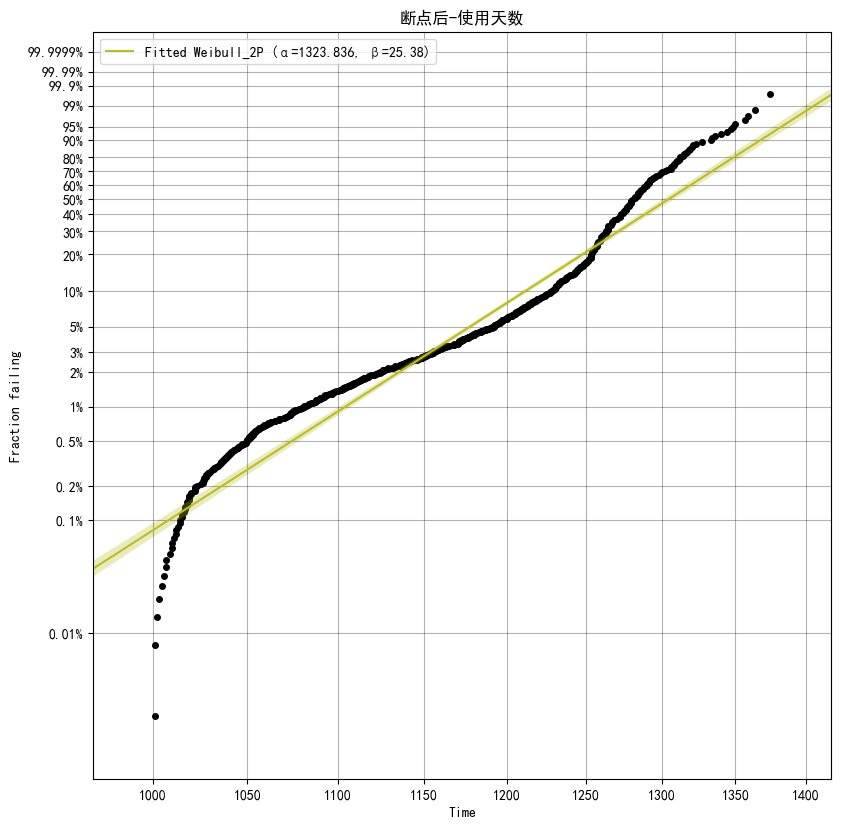

In [22]:
new_rate = 0
out = pd.DataFrame()
out['里程'] = [10000*i for i in range(1,16)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['里程'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['里程'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['里程'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


new_rate = 0
out = pd.DataFrame()
out['use_days'] = [100*i for i in range(1,20)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['use_days'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


left_data = claims.loc[(claims['product_date']>'2021-01-15')&(claims['use_days']>1000)]
right_data= vehicle.loc[(vehicle['product_date']>'2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
plt.title('断点后-使用天数')


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: L-BFGS-B
Failures / Right censored: 6529/33350 (83.62797% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1724.88          3.4399   1718.15   1731.64
     Beta         9.42316       0.0906893   9.24707   9.60259 

Goodness of fit    Value
 Log-likelihood -54955.2
           AICc   109914
            BIC   109931
             AD  505.773 



1825

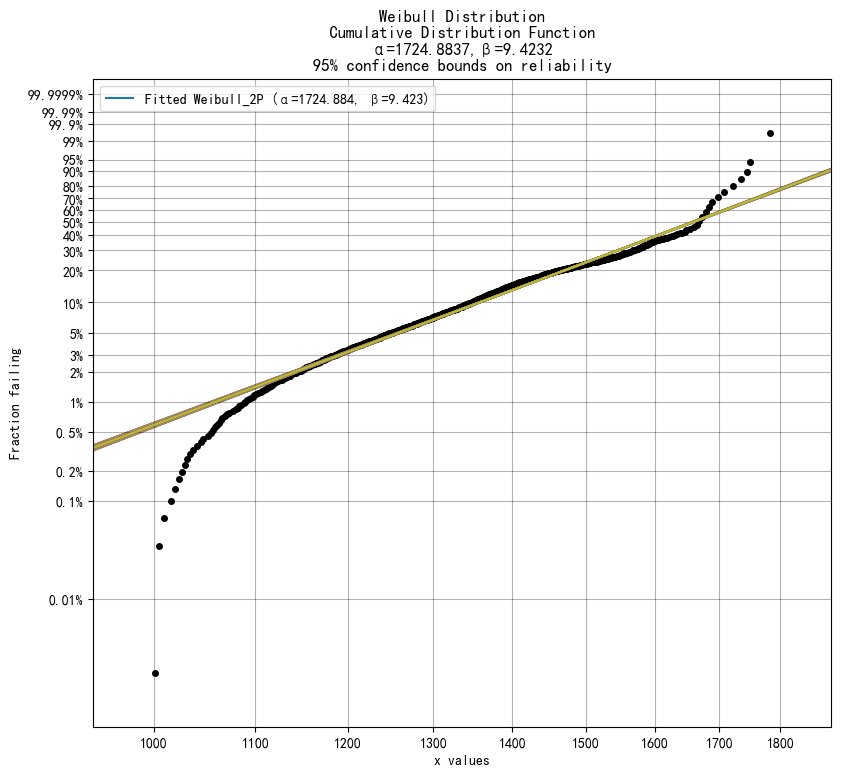

In [23]:
left_data = claims.loc[(claims['product_date']<='2021-01-15')&(claims['use_days']>1000)]
right_data= vehicle.loc[(vehicle['product_date']<='2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
plt.title('断点后-使用天数')



new_rate = 0
out = pd.DataFrame()
out['使用天数'] = [200*i for i in range(1,10)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['使用天数'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['使用天数'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['使用天数'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


5*365
# 供应商保修 3年6万， 理想汽车5年10万